# Example showing how to train the CNN
## Training without a GPU takes a very long time

In [1]:
%matplotlib inline

import numpy as np
import time
import os
import sys
import random
import gc

import matplotlib.pyplot as plt

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn

# This demonstration uses the validation data as training data 
### (the separate full training data cannot fit on the git repository)

In [3]:
map_size = 256
n_test = int(1000)
n_epoch = 20
batch_size = 32
learning_rate = 1e-5

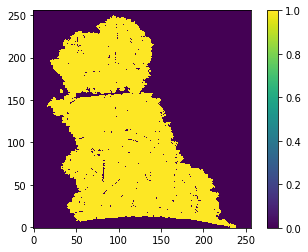

In [5]:
mask = np.float32(np.real(np.where(np.load('./picola_training/Ncov.npy') > 1.0, 0.0, 1.0)))
_ = plt.imshow(mask, origin='lower', clim=(0,1)), plt.colorbar()

In [6]:
wiener_array = np.load('./picola_training/validation_data/test_array_wiener.npy')
gc.collect()

52

In [7]:
clean_array = np.load('./picola_training/validation_data/test_array_clean.npy')
gc.collect()

30

In [8]:
train_array_noisy = wiener_array[n_test:]
train_array_clean = clean_array[n_test:]

test_array_noisy = wiener_array[:n_test]
test_array_clean = clean_array[:n_test:]
gc.collect()

22

In [9]:
train_gen = cnn.BatchGenerator(train_array_noisy, train_array_clean, gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy, test_array_clean, gen_batch_size=batch_size)

# Load and train model

In [10]:
cnn_instance = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model = cnn_instance.model()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=n_epoch,
                         steps_per_epoch=np.ceil(train_array_noisy.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)))

gc.collect()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0134 - val_loss: 0.0023
Epoch 2/20
219/219 [==============================] - 15s 71ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 3/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 4/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/20
219/219 [==============================] - 15s 70ms/step - loss: 9.0958e-04 - val_loss: 0.0010
Epoch 6/20
219/219 [==============================] - 15s 70ms/step - loss: 7.8208e-04 - val_loss: 8.6497e-04
Epoch 7/20
219/219 [==============================] - 15s 70ms/step - loss: 7.1007e-04 - val_loss: 7.3782e-04
Epoch 8/20
219/219 [==============================] - 15s 70ms/step - loss: 6.5570e-04 - val_loss: 6.4359e-04
Epoch 9/20
219/219 [==============================] - 15s 70ms/step - loss: 6.25

29

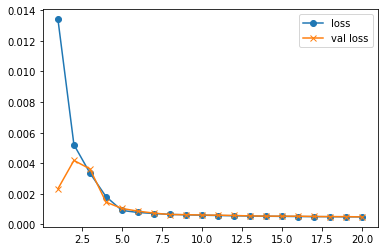

In [12]:
_ = plt.plot(np.arange(n_epoch)+1., history.history['loss'], label = 'loss', marker = 'o')
_ = plt.plot(np.arange(n_epoch)+1., history.history['val_loss'], label = 'val loss', marker = 'x')
_ = plt.legend()

# Apply model

In [13]:
test_output = cnn_model.predict(test_array_noisy)

In [14]:
print('Result MSE =' + str(mf.mean_square_error(test_array_clean.flatten(),
                                                test_output.flatten())))

Result MSE =0.00048782572


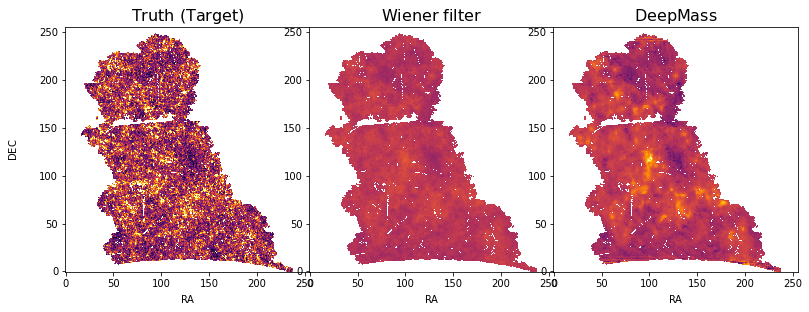

In [15]:
xticks=[None,'65°','75°','85°']
yticks=[]

_ = plt.figure(figsize =(15,4.5))
_ = plt.subplot(1,3,1), plt.title(r'${\rm Truth\ (Target)}$', fontsize=16)
_ = plt.imshow(np.where(mask!=0., (test_array_clean[0,:,:,0] -0.5)/3, np.nan),
               origin='lower', cmap='inferno', clim = (-0.025,0.025))


plt.xlabel(r'${\rm RA}$')
plt.ylabel(r'${\rm DEC}$', labelpad = 20.)

_ = plt.subplot(1,3,2), plt.title(r'${\rm Wiener\ filter}$', fontsize=16)
_ = plt.imshow(np.where(mask!=0., (test_array_noisy[0,:,:,0] -0.5)/3, np.nan),
               origin='lower', cmap='inferno', clim = (-0.025,0.025))

plt.xlabel(r'${\rm RA}$')

_ = plt.subplot(1,3,3), plt.title(r'${\rm DeepMass}$', fontsize=16)
_ = plt.imshow(np.where(mask!=0., (test_output[0,:,:,0] -0.5)/3, np.nan),
               origin='lower', cmap='inferno', clim = (-0.025,0.025))
plt.xlabel(r'${\rm RA}$')

plt.subplots_adjust(wspace=-0.3)
